<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>


#### Classify handwritten digits using the famous MNIST data

The goal in this task is to take an image of a handwritten single digit, and determine what that digit is.  

The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import Image
from IPython.core.display import HTML

2022-05-18 12:05:58.252600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 12:05:58.252645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
datapath = "./data/"
outputs = "./data/"

In [3]:
# read training data from CSV file 

with ZipFile(os.path.join(datapath, 'kaggle_digits_train.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_train.csv') as myfile:
        train_data = pd.read_csv(myfile)
        
with ZipFile(os.path.join(datapath, 'kaggle_digits_test.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_test.csv') as myfile:
        test_data = pd.read_csv(myfile)

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [4]:
sample_size = 4200

images = train_data.iloc[:sample_size, 1:].values   # Decreasing the number of images to save memory
images = images.astype(np.float16)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images numpy array have shape: ({0[0]},{0[1]})'.format(images.shape))

images numpy array have shape: (4200,784)


In [5]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [6]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


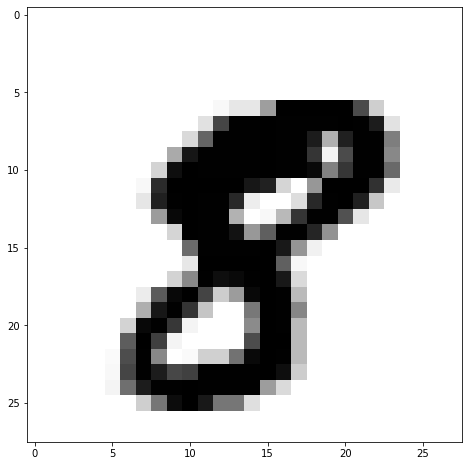

In [7]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [8]:
labels_flat = train_data.iloc[:sample_size, 0].values   # Adjusting the number of labels to the number of images selected

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(4200)
labels_flat[10] => 8


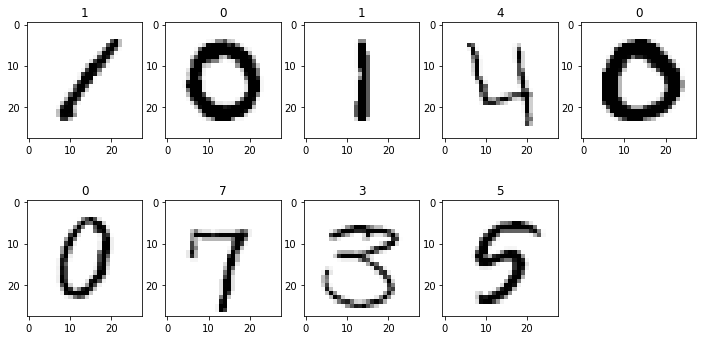

In [9]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = images[i,:].reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(labels_flat[i])

In [10]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [11]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_images = test_data.values.astype(np.float16)
test_images.shape

(28000, 784)

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels_flat, 
                                                                    test_size=0.4, 
                                                                    random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(2520,784)
validation images(1680,784)
train labels((2520,))
validation labels((1680,))


In [14]:
del(images)  #save memory

In [15]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

0.9392857142857143


In [16]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.9416666666666667


Making Predictions

In [17]:
predict_rf = clf_rf.predict(test_images)
predict_rf[0:10]

array([2, 0, 9, 9, 2, 7, 0, 3, 0, 3])

In [18]:
predict_svm = clf_svm.predict(test_images)
predict_svm[0:10]

array([2, 0, 9, 0, 2, 7, 0, 3, 0, 3])

### Using Tensor Flow (with a fully connected ANN)

In [19]:
import tensorflow as tf

Train: X=(2520, 28, 28), y=(2520,)
Test: X=(1680, 28, 28), y=(1680,)


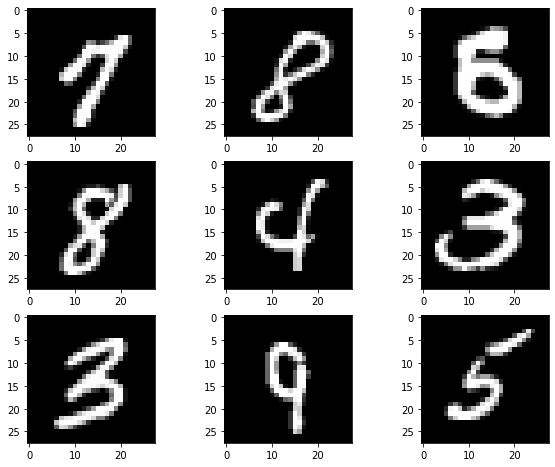

In [20]:
X_train = X_train.reshape(X_train.shape[0],28,28)
X_test = X_test.reshape(X_test.shape[0],28,28)
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [21]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2022-05-18 12:06:22.360273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 12:06:22.360324: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 12:06:22.360354: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (21099d30f8a5): /proc/driver/nvidia/version does not exist
2022-05-18 12:06:22.360595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
%time model.fit(X_train, y_train, epochs=10)
model.evaluate(X_test,  y_test, verbose=1)

Epoch 1/10
79/79 [==============================] - 1s 2ms/step - loss: 1.1001 - accuracy: 0.6837
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.4593 - accuracy: 0.8702
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 0.3496 - accuracy: 0.9036
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.2831 - accuracy: 0.9250
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.2407 - accuracy: 0.9333
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.9448
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9571
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9671
Epoch 9/10
79/79 [==============================] - 0s 2ms/step - loss: 0.1239 - accuracy: 0.9687
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9766
CPU times: user 2.6

[0.2519620358943939, 0.9232142567634583]

### Using Tensor Flow (with a CNN)

### a) simple model

In [23]:
# reshape dataset to have a single channel
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)
#y_train = y_train.reshape(y_train.shape[0])
#y_test = y_test.reshape(y_test.shape[0])

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu', 
                                                           kernel_initializer='he_uniform', 
                                                           input_shape=(28, 28, 1)
                                                          ),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
                                    tf.keras.layers.Dense(10, activation='softmax'),
                                   ])

model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9)
              loss="sparse_categorical_crossentropy",
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

In [24]:
%time model.fit(X_train, y_train, epochs=10, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
79/79 [==============================] - 2s 15ms/step - loss: 0.6621 - accuracy: 0.7944
Epoch 2/10
79/79 [==============================] - 1s 15ms/step - loss: 0.2449 - accuracy: 0.9270
Epoch 3/10
79/79 [==============================] - 1s 15ms/step - loss: 0.1389 - accuracy: 0.9639
Epoch 4/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0749 - accuracy: 0.9837
Epoch 5/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0445 - accuracy: 0.9901
Epoch 6/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0261 - accuracy: 0.9980
Epoch 7/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0130 - accuracy: 0.9992
Epoch 8/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 9/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 10/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0041 - accuracy: 1.0000
CPU times

[0.18683333694934845, 0.9565476179122925]

### b) slightly bigger model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1)
                                ))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              #loss='categorical_crossentropy',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(X_train, y_train,batch_size=32, epochs=10, verbose=1, \
                          validation_data=(X_test, y_test), callbacks=[early_stopping])
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
79/79 [==============================] - 6s 75ms/step - loss: 0.9600 - accuracy: 0.6933 - val_loss: 0.2701 - val_accuracy: 0.9286
Epoch 2/10
79/79 [==============================] - 6s 73ms/step - loss: 0.3124 - accuracy: 0.9115 - val_loss: 0.1831 - val_accuracy: 0.9452
Epoch 3/10
79/79 [==============================] - 6s 73ms/step - loss: 0.2065 - accuracy: 0.9369 - val_loss: 0.1507 - val_accuracy: 0.9548
Epoch 4/10
79/79 [==============================] - 6s 76ms/step - loss: 0.1545 - accuracy: 0.9528 - val_loss: 0.1574 - val_accuracy: 0.9542
Epoch 5/10
79/79 [==============================] - 6s 74ms/step - loss: 0.1234 - accuracy: 0.9619 - val_loss: 0.1386 - val_accuracy: 0.9601
Epoch 6/10
79/79 [==============================] - 6s 73ms/step - loss: 0.1053 - accuracy: 0.9647 - val_loss: 0.1421 - val_accuracy: 0.9583
Epoch 7/10
79/79 [==============================] - 6s 73ms/step - loss: 0.0899 - accuracy: 0.9734 - val_loss: 0.1302 - val_accuracy: 0.9649
Epoch 8/10
79

[0.14814448356628418, 0.9642857313156128]

In [28]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

53/53 [==============================] - 1s 14ms/step - loss: 0.1481 - accuracy: 0.9643
Test loss: 0.14814448356628418
Test accuracy: 0.9642857313156128


In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.959960,0.693254,0.270084,0.928571
1,0.312430,0.911508,0.183114,0.945238
2,0.206530,0.936905,0.150736,0.954762
3,0.154466,0.952778,0.157409,0.954167
4,0.123405,0.961905,0.138599,0.960119


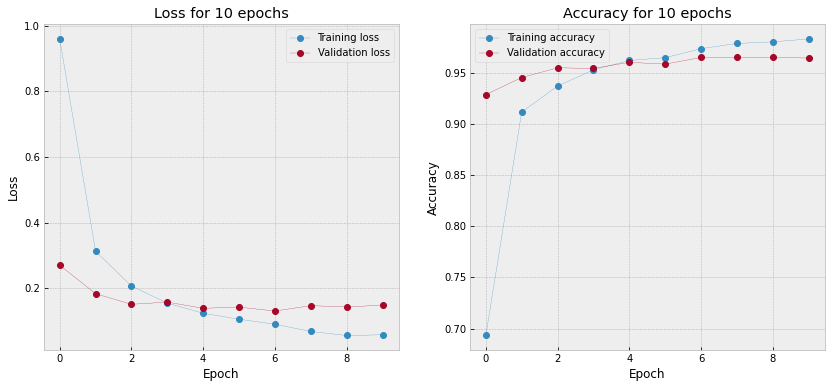

In [30]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### c) [Using the LENET architecture](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/  )

![](./img/lenet_architecture-768x226.png)

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.  

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.  

However, if you do have GPU support and can access your GPU via Keras, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).  

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=20, kernel_size = (5, 5), padding = "same", input_shape = (28, 28, 1)))
model.add(tf.keras.layers.Activation(activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides =  (2, 2)))
model.add(tf.keras.layers.Convolution2D(filters=50, kernel_size = (5, 5), padding = "same"))
model.add(tf.keras.layers.Activation(activation= "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500))
model.add(tf.keras.layers.Activation(activation = "relu"))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation("softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              #loss='categorical_crossentropy',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(X_test, y_test), callbacks=[early_stopping])

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
79/79 [==============================] - 5s 62ms/step - loss: 0.6403 - accuracy: 0.8004 - val_loss: 0.2115 - val_accuracy: 0.9321
Epoch 2/10
79/79 [==============================] - 5s 61ms/step - loss: 0.1768 - accuracy: 0.9476 - val_loss: 0.1485 - val_accuracy: 0.9554
Epoch 3/10
79/79 [==============================] - 5s 60ms/step - loss: 0.1009 - accuracy: 0.9687 - val_loss: 0.1402 - val_accuracy: 0.9595
Epoch 4/10
79/79 [==============================] - 5s 60ms/step - loss: 0.0588 - accuracy: 0.9817 - val_loss: 0.1563 - val_accuracy: 0.9512
Epoch 5/10
79/79 [==============================] - 5s 66ms/step - loss: 0.0398 - accuracy: 0.9905 - val_loss: 0.1157 - val_accuracy: 0.9696
Epoch 6/10
79/79 [==============================] - 5s 61ms/step - loss: 0.0267 - accuracy: 0.9909 - val_loss: 0.1292 - val_accuracy: 0.9643
Epoch 7/10
79/79 [==============================] - 5s 61ms/step - loss: 0.0225 - accuracy: 0.9925 - val_loss: 0.1616 - val_accuracy: 0.9583
Epoch 8/10
79

[0.14367106556892395, 0.9660714268684387]

In [33]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

53/53 [==============================] - 1s 14ms/step - loss: 0.1437 - accuracy: 0.9661
Test loss: 0.14367106556892395
Test accuracy: 0.9660714268684387


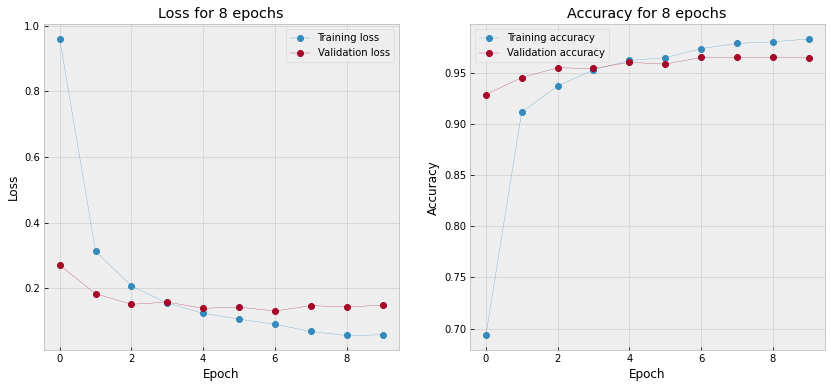

In [34]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### d) Testing a more complex model

![](https://sihamtabik.github.io/LeNet-like-CNN.jpg)

In [35]:
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=(28, 28, 1),))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              #loss='categorical_crossentropy',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 30, 30, 1)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(X_test, y_test), callbacks=[early_stopping])
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
 1/79 [..............................] - ETA: 1:09 - loss: 2.3063 - accuracy: 0.0312

2022-05-18 12:08:23.454484: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27998208 exceeds 10% of free system memory.


 2/79 [..............................] - ETA: 15s - loss: 2.3016 - accuracy: 0.0938 

2022-05-18 12:08:23.665787: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27998208 exceeds 10% of free system memory.
2022-05-18 12:08:23.864864: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27998208 exceeds 10% of free system memory.


 4/79 [>.............................] - ETA: 15s - loss: 2.2992 - accuracy: 0.1172

2022-05-18 12:08:24.068931: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27998208 exceeds 10% of free system memory.
2022-05-18 12:08:24.268387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27998208 exceeds 10% of free system memory.


79/79 [==============================] - 19s 227ms/step - loss: 1.4456 - accuracy: 0.4833 - val_loss: 0.4513 - val_accuracy: 0.8560
Epoch 2/10
79/79 [==============================] - 18s 222ms/step - loss: 0.3180 - accuracy: 0.9028 - val_loss: 0.3089 - val_accuracy: 0.9226
Epoch 3/10
79/79 [==============================] - 18s 225ms/step - loss: 0.2044 - accuracy: 0.9349 - val_loss: 0.2644 - val_accuracy: 0.9113
Epoch 4/10
79/79 [==============================] - 18s 224ms/step - loss: 0.1386 - accuracy: 0.9571 - val_loss: 0.1470 - val_accuracy: 0.9554
Epoch 5/10
79/79 [==============================] - 18s 223ms/step - loss: 0.1049 - accuracy: 0.9694 - val_loss: 0.1664 - val_accuracy: 0.9500
Epoch 6/10
79/79 [==============================] - 19s 243ms/step - loss: 0.0721 - accuracy: 0.9758 - val_loss: 0.1344 - val_accuracy: 0.9595
Epoch 7/10
79/79 [==============================] - 18s 226ms/step - loss: 0.0457 - accuracy: 0.9869 - val_loss: 0.1388 - val_accuracy: 0.9637
Epoch 8/10

[0.1210591197013855, 0.9702380895614624]

In [37]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

53/53 [==============================] - 2s 37ms/step - loss: 0.1211 - accuracy: 0.9702
Test loss: 0.1210591197013855
Test accuracy: 0.9702380895614624


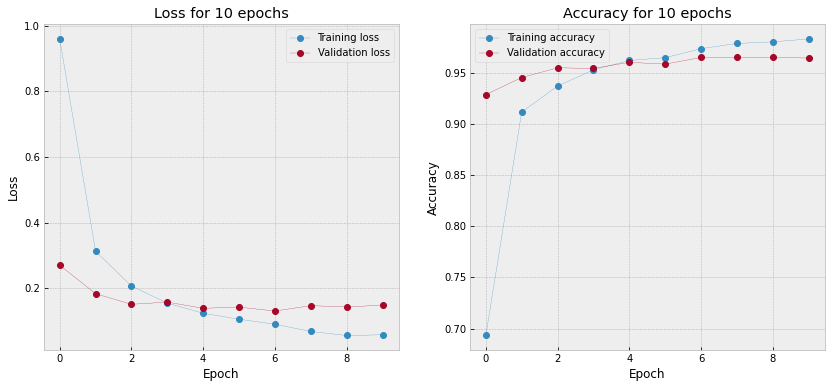

In [38]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Pre-trained models  

How can I use pre-trained models in Keras?  
Code and pre-trained weights are available for the following image classification models:  
+ Xception  
+ VGG16  
+ VGG19  
+ ResNet50  
+ Inception v3  

They can be imported from the module [keras.applications](https://keras.io/applications/):

In [39]:
#from keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

#model = VGG16(weights='imagenet', include_top=True)

[Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)
[Visualizing the classification task:](http://scs.ryerson.ca/~aharley/vis/fc/)